# Kaggle : Gemstone Price Prediction
https://www.kaggle.com/competitions/playground-series-s3e8/overview

In [27]:
#0 Load libraries

import numpy as np
import pandas as pd

import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import RandomizedSearchCV

## 1. Load data and pre-processing

In [29]:
#1.1 Load train data
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [30]:
#1.2 Load test data
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,193573,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,193574,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,193575,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,193576,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,193577,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24


In [31]:
#1.3 Check info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [32]:
#1.4 Confirm NA
train_df.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [44]:
#1.5 Splitting data with 70-30 ratio
train, valid = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=123)
train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
139244,139244,0.41,Ideal,E,VS1,62.6,56.0,4.77,4.73,2.97,1073
146166,146166,0.30,Very Good,G,SI2,62.5,57.0,4.24,4.28,2.66,365
43536,43536,0.38,Ideal,E,VS2,61.8,54.0,4.66,4.69,2.89,935
151742,151742,2.11,Premium,F,SI2,61.0,60.0,8.29,8.33,5.06,14067
86034,86034,0.31,Ideal,E,SI1,61.5,55.0,4.38,4.40,2.70,489


In [45]:
#1.6 Copy test data
test = test_df.copy()

In [46]:
#1.7 Check size of each dataset
print('Train data -shape', train.shape)
print('Valid data -shape', valid.shape)
print('Test data  -shape', test.shape)

Train data -shape (135501, 11)
Valid data -shape (58072, 11)
Test data  -shape (129050, 10)


## 2. EDA

In [47]:
#2.1 Check info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135501 entries, 139244 to 15725
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       135501 non-null  int64  
 1   carat    135501 non-null  float64
 2   cut      135501 non-null  object 
 3   color    135501 non-null  object 
 4   clarity  135501 non-null  object 
 5   depth    135501 non-null  float64
 6   table    135501 non-null  float64
 7   x        135501 non-null  float64
 8   y        135501 non-null  float64
 9   z        135501 non-null  float64
 10  price    135501 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 12.4+ MB


In [48]:
#2.2 Pulling all features
train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price'],
      dtype='object')

In [49]:
#2.3 Separate features into each group
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
discreteized_features = []
categorical_features = ['cut', 'color', 'clarity']
text_features = []
drop_features = ['id']

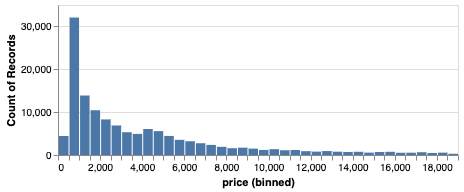

In [50]:
#2.3.1 Numerical feature distributions - price
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('price', type='quantitative', bin=alt.Bin(maxbins=40)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

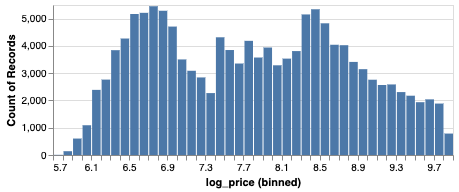

In [51]:
#2.3.2 Numerical feature distributions - log_price
train['log_price'] = np.log(train['price'])
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('log_price', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

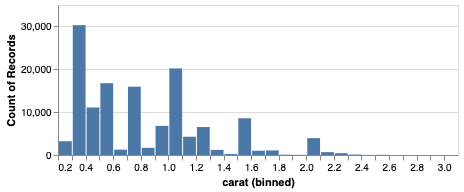

In [52]:
#2.3.3 Numerical feature distributions - carat
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('carat', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

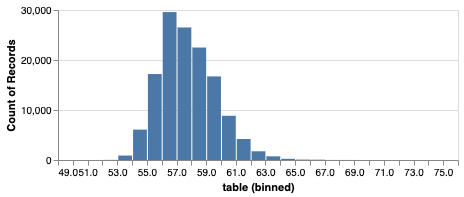

In [53]:
#2.3.4 Numerical feature distributions - table
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('table', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

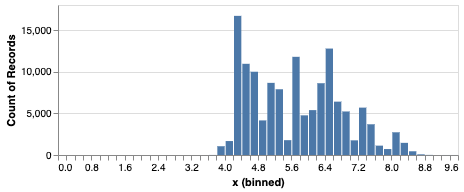

In [56]:
#2.3.5 Numerical feature distributions - x
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('x', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

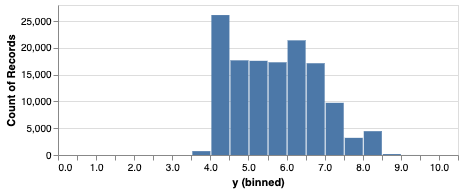

In [57]:
#2.3.6 Numerical feature distributions - y
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('y', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

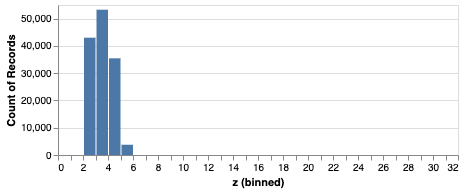

In [58]:
#2.3.7 Numerical feature distributions - z
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('z', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

In [59]:
#2.3.8.1 Categorical feature distributions - cut - value_counts()
train['cut'].value_counts()

Ideal        64560
Premium      34850
Very Good    26584
Good          8076
Fair          1431
Name: cut, dtype: int64

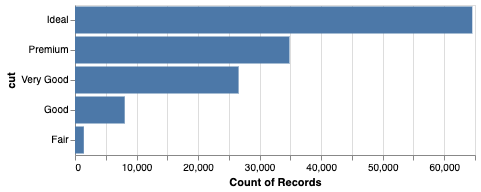

In [60]:
#2.3.8.2 Categorical feature distributions - cut
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('cut', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [64]:
#2.3.9.1 Categorical feature distributions - color - value_counts()
train['color'].value_counts()

G    31096
E    25103
F    24028
H    21601
D    16848
I    12312
J     4513
Name: color, dtype: int64

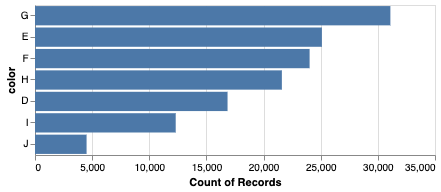

In [62]:
#2.3.9.2 Categorical feature distributions - color
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('color', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [63]:
#2.3.10.1 Categorical feature distributions - clarity - value_counts()
train['clarity'].value_counts()

SI1     37229
VS2     33521
VS1     21567
SI2     21247
VVS2    11143
VVS1     7450
IF       2982
I1        362
Name: clarity, dtype: int64

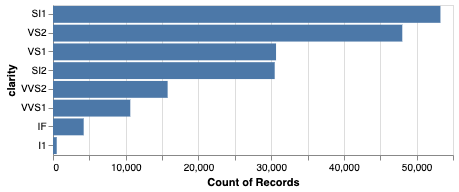

In [22]:
#2.3.9.10 Categorical feature distributions - clarity
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('clarity', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [65]:
#2.4 Correlation matrix : Spearman
train.corr('pearson').style.background_gradient().format(precision=2)

,id,carat,depth,table,x,y,z,price,log_price
id,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
carat,-0.00,1.00,0.03,0.23,0.98,0.98,0.97,0.94,0.94
depth,0.00,0.03,1.00,-0.23,-0.01,-0.01,0.08,0.00,0.01
table,0.00,0.23,-0.23,1.00,0.24,0.23,0.21,0.17,0.21
x,-0.00,0.98,-0.01,0.24,1.00,1.00,0.99,0.90,0.97
y,-0.00,0.98,-0.01,0.23,1.00,1.00,0.99,0.90,0.97
z,0.00,0.97,0.08,0.21,0.99,0.99,1.00,0.89,0.96
price,-0.00,0.94,0.00,0.17,0.90,0.90,0.89,1.00,0.90
log_price,-0.00,0.94,0.01,0.21,0.97,0.97,0.96,0.90,1.00


In [67]:
#2.5 Correlation matrix : Spearman
train.corr('spearman').style.background_gradient().format(precision=2)

,id,carat,depth,table,x,y,z,price,log_price
id,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
carat,-0.00,1.00,0.04,0.24,1.00,1.00,1.00,0.97,0.97
depth,0.00,0.04,1.00,-0.16,-0.01,-0.01,0.11,0.03,0.03
table,0.00,0.24,-0.16,1.00,0.24,0.23,0.21,0.22,0.22
x,-0.00,1.00,-0.01,0.24,1.00,1.00,0.99,0.97,0.97
y,-0.00,1.00,-0.01,0.23,1.00,1.00,0.99,0.97,0.97
z,0.00,1.00,0.11,0.21,0.99,0.99,1.00,0.97,0.97
price,0.00,0.97,0.03,0.22,0.97,0.97,0.97,1.00,1.00
log_price,0.00,0.97,0.03,0.22,0.97,0.97,0.97,1.00,1.00


## 3. Feature engineering and Feature selection

In [68]:
#3.1 Separate X_train, y_train, X_test, y_test
X_train = train.drop(columns=['price'])
X_test = valid.drop(columns=['price'])
y_train = train['price']
y_test = valid['price']

In [70]:
#3.2 Check colnume names
X_train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'log_price'],
      dtype='object')

In [78]:
#3.3 setup feature types
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']
drop_features = ['id','log_price']

cut_list = ['Ideal','Premium','Very Good','Good','Fair']
color_list = ['D','E','F','G','H','I','J']
clarity_list = ['IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1']

# 3.4 define pre-processor
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    # (OneHotEncoder(handle_unknown="ignore"), categorical_features), 
    (OrdinalEncoder(categories=[cut_list,color_list,clarity_list], dtype=int, handle_unknown='error'), categorical_features),
    ("drop", drop_features)
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Ideal', 'Premium',
                                                             'Very Good',
                                                             'Good', 'Fair'],
                                                            ['D', 'E', 'F', 'G',
                                                             'H', 'I', 'J'],
                                                            ['IF', 'VVS1',
                                                             'VVS2', 'VS1',
                                                             'VS2', 'SI1',
                                                             'SI2', 'I1']],
                                                dtype=<class 'int'>),
                                 ['cut', 'color', 'clarity']),
                                ('drop', 'drop', ['id', 'log_price'])])

# 4. Modeling

In [79]:
# 4.0 Initial model result
cross_val_results = {}

In [86]:
# 4.1.1 Baseline model with DummyRegressor
dc = make_pipeline(preprocessor, DummyRegressor())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        dc, X_train, y_train, 
        cv = 5,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.075918,0.011785,-4029.521055,-4037.283922
1,0.049876,0.010402,-4036.905726,-4035.437562
2,0.047413,0.010212,-4039.445006,-4034.802011
3,0.046965,0.010210,-4047.335599,-4032.827527
4,0.046952,0.010373,-4025.465914,-4038.295010


In [87]:
# 4.1.2 Store CV score
cross_val_results['dummy'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['dummy']

,mean,std
fit_time,0.053,0.013
score_time,0.011,0.001
test_score,-4035.735,8.570
train_score,-4035.729,2.143


In [88]:
#4.2.1 Linear regression model
linreg = make_pipeline(preprocessor, LinearRegression())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        linreg, X_train, y_train, 
        cv = 5,
        n_jobs = -1,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.071824,0.010529,-1023.436276,-1018.663085
1,0.072206,0.010897,-1020.480736,-1016.244742
2,0.075418,0.015064,-1028.900725,-1014.102829
3,0.065847,0.010438,-1012.906579,-1018.112278
4,0.073429,0.012254,-1014.392894,-1017.743759


In [89]:
#4.2.2 Store CV score
cross_val_results['linreg'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['linreg']

,mean,std
fit_time,0.072,0.004
score_time,0.012,0.002
test_score,-1020.023,6.577
train_score,-1016.973,1.838


In [92]:
#4.3.1 RidgeCV
ridge = make_pipeline(preprocessor, RidgeCV())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        ridge, X_train, y_train, 
        cv = 10,
        n_jobs = -1,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.099434,0.006158,-1029.911174,-1019.461845
1,0.089571,0.006850,-1026.897822,-1015.971241
2,0.093069,0.006197,-1020.057002,-1016.745977
3,0.095775,0.008268,-1020.824616,-1016.657571
4,0.092522,0.007273,-1026.260484,-1016.043850
5,0.101765,0.006266,-1031.520151,-1015.454862
6,0.096086,0.006470,-1009.816148,-1017.872193
7,0.096850,0.007502,-1016.069214,-1017.196045
8,0.090857,0.006371,-1031.045682,-1015.512102
9,0.098308,0.006620,-997.609079,-1019.209528


In [93]:
#4.3.2 Store CV score
cross_val_results['ridgecv'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['ridgecv']

,mean,std
fit_time,0.095,0.004
score_time,0.007,0.001
test_score,-1021.001,10.806
train_score,-1017.013,1.434


In [106]:
10.0 ** np.arange(-10, 100, 1)

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13,
       1.e+14, 1.e+15, 1.e+16, 1.e+17, 1.e+18, 1.e+19, 1.e+20, 1.e+21,
       1.e+22, 1.e+23, 1.e+24, 1.e+25, 1.e+26, 1.e+27, 1.e+28, 1.e+29,
       1.e+30, 1.e+31, 1.e+32, 1.e+33, 1.e+34, 1.e+35, 1.e+36, 1.e+37,
       1.e+38, 1.e+39, 1.e+40, 1.e+41, 1.e+42, 1.e+43, 1.e+44, 1.e+45,
       1.e+46, 1.e+47, 1.e+48, 1.e+49, 1.e+50, 1.e+51, 1.e+52, 1.e+53,
       1.e+54, 1.e+55, 1.e+56, 1.e+57, 1.e+58, 1.e+59, 1.e+60, 1.e+61,
       1.e+62, 1.e+63, 1.e+64, 1.e+65, 1.e+66, 1.e+67, 1.e+68, 1.e+69,
       1.e+70, 1.e+71, 1.e+72, 1.e+73, 1.e+74, 1.e+75, 1.e+76, 1.e+77,
       1.e+78, 1.e+79, 1.e+80, 1.e+81, 1.e+82, 1.e+83, 1.e+84, 1.e+85,
       1.e+86, 1.e+87, 1.e+88, 1.e+89, 1.e+90, 1.e+91, 1.e+92, 1.e+93,
       1.e+94, 1.e+95, 1.e+96, 1.e+97, 1.e+98, 1.e+99])

In [107]:
#4.4.1 Ridge with RandomizedSearchCV
ridge = make_pipeline(preprocessor, Ridge())

param_grid = {
    "ridge__alpha": 10.0 ** np.arange(-10, 10, 1)
}
random_search_ridge = RandomizedSearchCV(
    ridge, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=10, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_ridge.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']]...
                                                                                'color',
                                                                                'clarity']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['id',
                                                                                'log_price'])])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': arr

In [108]:
#4.4.2 CV result - Ridge with RandomizedSearchCV
result_ridge = pd.DataFrame(random_search_ridge.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "param_ridge__alpha",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_ridge.iloc[0,0:4]),
        'std': list(result_ridge.iloc[0,4:8])}
cross_val_results['ridge'] = pd.DataFrame(data)
cross_val_results['ridge'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['ridge']

,mean,std
fit_time,0.063126,0.002064
score_time,0.006325,0.000288
test_score,-1021.028120,10.279040
train_score,-1017.010250,1.357760


In [109]:
#4.4.3 Find best param
rp_ridge = random_search_ridge.best_params_
rp_ridge

{'ridge__alpha': 0.01}

In [ ]:
#4.5 Different nonlinear models
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1,random_state=123))
pipe_xgb = make_pipeline(preprocessor, xg.XGBRegressor(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
pipe_cat = make_pipeline(preprocessor, CatBoostRegressor(verbose=0, random_state=123))

regressors = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_cat
}

for (name, model) in regressors.items():
    cross_val_results[name] = pd.DataFrame(cross_validate(
        model, X_train, y_train, cv=5,
        return_train_score=True, 
        scoring = 'neg_root_mean_squared_error'
    )).agg(['mean', 'std']).round(3).T
                                            
pd.concat(cross_val_results, axis=1)

# 5. Feature Selection

In [ ]:
# 1. Setup the pipeline
lasso_lgbm = make_pipeline(preprocessor,
                            SelectFromModel(LassoCV(max_iter=20000, tol=0.01)),
                            LGBMRegressor(random_state=123))

# 2. Cross-validation
cv_df = pd.DataFrame(
cross_validate(
    lasso_lgbm, X_train, y_train, 
    cv = 10,
    return_train_score = True, 
    scoring = 'neg_root_mean_squared_error'
))
cv_df 